# Classification

In [37]:
import pandas as pd
import numpy as np

# Metrics and model evaluation
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, learning_curve, validation_curve, cross_validate
from sklearn.pipeline import Pipeline

# Classifiers
import wittgenstein as lw
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# Visualization
from IPython.display import Image, Markdown, display
from sklearn.decomposition import PCA
import pydotplus

import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import plotly.figure_factory as ff
pd.options.plotting.backend = "plotly"
pio.templates.default = "seaborn"

pd.set_option('display.max_columns', None)

import warnings
def warn(*args, **kwargs):
    pass
warnings.warn = warn

## Helper class

This class is used to split the data into train and test and then is used to show a report for each classifier, that contains info about the validation and the test

In [38]:
class Classification:
  
  # constructors that takes models and data
  def __init__(self, X, Y, classes, cv=5):
    self._models = []
    self.X = X
    self.Y = Y
    self.classes = classes
    # Split the data into training and test sets with a test size of 30%
    self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, Y, stratify=Y, test_size=0.3, random_state=0)
    self._cv = cv

  # This function executes a grid search for a specific model and then saves the best model and its parameters
  def show_report(self, estimator_name, estimator, parameters, validation_parameter, normalization=True):
    # add clf to parameters
    parameters = {'clf__' + k: v for k, v in parameters.items()}
    validation_parameter = 'clf__' + validation_parameter

    # Execute grid search for the classifier given the parameters on the training set with 5-fold cross validation
    grid_search_clf = self._estimator_to_grid_search(estimator, parameters, cross_validation=self._cv, normalization=normalization)
    grid_search_clf.fit(self.x_train, self.y_train)
    
    # ========================
    # Report on VALIDATION SET
    # ========================
    display(Markdown('#### VALIDATION Report'))
    ## Show grid search results with the best top 10 results
    display(Markdown(f'##### Top 10 results of the grid search with {self._cv}-fold cross validation'))
    self._print_grid_search_results(grid_search_clf)

    # Print Validation metrics for the best model
    validation_scores = cross_validate(grid_search_clf.best_estimator_, self.x_train, self.y_train, cv=self._cv, scoring=["accuracy", "f1", "precision", "recall"])
    validation_scores = {k: round(np.mean(v), 4) for k, v in validation_scores.items()}
    display(Markdown(f'##### Validation metrics for the best model'))
    print("Accuracy: " + str(validation_scores['test_accuracy']))
    print("F1: " + str(validation_scores['test_f1']))
    print("Precision: " + str(validation_scores['test_precision']))
    print("Recall: " + str(validation_scores['test_recall']))

    # Plot the validation curve
    if parameters and validation_parameter:
      self._plot_validation_curve(grid_search_clf.best_estimator_, parameters, validation_parameter, cv=self._cv)

    # Plot the learning curve
    self._plot_learning_curve(grid_search_clf.best_estimator_, cv=self._cv)

    # ========================
    # Report on TEST SET
    # ========================
    display(Markdown('#### TEST Report'))
    # Test the best classifier on the test set
    y_pred = grid_search_clf.predict(self.x_test)

    # Get the best classifier of the grid search and add it to the list of best models
    self._models.append((estimator_name, grid_search_clf.best_estimator_))

    # Show the confusion matrix for the best classifier on the TEST set
    self._plot_confusion_matrix(y_pred, labels=grid_search_clf.classes_)

    ## Show the metrics for the best classifier on the TEST set
    display(Markdown('##### Metrics for the best classifier on the TEST set'))
    print(classification_report(self.y_test, y_pred, target_names=self.classes, zero_division=0, sample_weight=None))

    # Return the best classifier
    return grid_search_clf.best_estimator_

  # Return all best models tested with show_report
  def get_best_models(self):
    return self._models

  def _estimator_to_grid_search(self, estimator, parameters, cross_validation=5, normalization=True, random_state=42):
    estimator.random_state = random_state
    if normalization:
        pipeline = Pipeline(steps=[('scaler', MinMaxScaler()), ('clf', estimator)])
    else:
        pipeline = Pipeline(steps=[('clf', estimator)])

    return GridSearchCV(pipeline, param_grid=parameters, cv=cross_validation, n_jobs=-1, refit=True, return_train_score=True)

  def _print_grid_search_results(self, grid_search):
    df = pd.DataFrame(grid_search.cv_results_)[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']].sort_values(by='rank_test_score')

    # remove the 'clf__' prefix from the parameters column
    df['params'] = df['params'].apply(lambda x: {k[5:]: v for k, v in x.items()})
    # create a column for each parameter in params column in df_new
    df_new = pd.DataFrame()
    for param in df['params'].iloc[0].keys():
      df_new[param] = df['params'].apply(lambda x: x[param])
    # add old columns to new df
    df_new = df_new.join(df[['mean_train_score', 'mean_test_score', 'rank_test_score']])

    display(df_new.head(10).style.hide_index())

  def _plot_confusion_matrix(self, y_pred, labels, normalize=False):
    cm = confusion_matrix(self.y_test, y_pred, labels=labels)
    if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      display(Markdown('##### Normalized confusion matrix for the best classifier obtained by the Grid Search on the TEST set'))
    else:
      display(Markdown('##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set'))

    # px.imshow(cm, x=classes, y=classes, title='Confusion matrix', color_continuous_scale="Blues", labels=dict(x="Real value", y="Predicted value", color="Records"), text_auto=True)
    fig = ff.create_annotated_heatmap(cm[[1, 0]], x=self.classes, y=self.classes, colorscale='Blues', showscale=True)
    fig.update_layout(xaxis = dict(title='Predicted value'), yaxis = dict(title='Real value'))
    fig.show()

  def _plot_learning_curve(self, clf, scoring='accuracy', cv=5, train_sizes=np.linspace(.1, 1.0, 5), shuffle=False, random_state=None):

    train_sizes, train_scores, test_scores = learning_curve(clf, self.x_train, self.y_train, train_sizes=train_sizes, cv=cv,
                                                            scoring=scoring, n_jobs=-1, shuffle=shuffle,
                                                            random_state=random_state)
    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=train_sizes, y=mean_train_score, name='train score', line=dict(color='royalblue')))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_train_score + std_train_score, mode="lines", showlegend=False, line=dict(width=0)))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_train_score - std_train_score, fill='tonexty', showlegend=False, 
      fillcolor='rgba(65,105,225,0.2)',
      line_color='rgba(255,255,255,0)',))

    fig.add_trace(go.Scatter(x=train_sizes, y=mean_test_score, name='cross-validation score', line=dict(color='firebrick')))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_test_score + std_test_score, mode="lines", showlegend=False, line=dict(width=0)))
    fig.add_trace(go.Scatter(x=train_sizes, y=mean_test_score - std_test_score, fill='tonexty', showlegend=False, 
      fillcolor='rgba(255,107,107,0.2)',
      line_color='rgba(255,255,255,0)',))

    model_name = str(clf["clf"].__class__.__name__)
    fig.update_layout(title=f'Learning Curve for {model_name}',
                   xaxis_title='Train set size',
                   yaxis_title='Accuracy')
    fig.show()

  def _plot_validation_curve(self, clf, parameters, validation_parameter, scoring='accuracy', cv=5):
    param_range = parameters[validation_parameter]
    train_scores, test_scores = validation_curve(clf, self.x_train, self.y_train, param_name=validation_parameter, param_range=param_range,
                                                  cv=cv, scoring=scoring, n_jobs=-1)
    mean_train_score = np.mean(train_scores, axis=1)
    std_train_score = np.std(train_scores, axis=1)
    mean_test_score = np.mean(test_scores, axis=1)
    std_test_score = np.std(test_scores, axis=1)

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=param_range, y=mean_train_score, name='train score', line=dict(color='royalblue')))
    fig.add_trace(go.Scatter(x=param_range, y=mean_train_score + std_train_score, mode="lines", showlegend=False, line=dict(width=0)))
    fig.add_trace(go.Scatter(x=param_range, y=mean_train_score - std_train_score, fill='tonexty', showlegend=False, 
      fillcolor='rgba(65,105,225,0.2)',
      line_color='rgba(255,255,255,0)',))

    fig.add_trace(go.Scatter(x=param_range, y=mean_test_score, name='cross-validation score', line=dict(color='firebrick')))
    fig.add_trace(go.Scatter(x=param_range, y=mean_test_score + std_test_score, mode="lines", showlegend=False, line=dict(width=0)))
    fig.add_trace(go.Scatter(x=param_range, y=mean_test_score - std_test_score, fill='tonexty', showlegend=False, 
      fillcolor='rgba(255,107,107,0.2)',
      line_color='rgba(255,255,255,0)',))

    param_name = str(validation_parameter).replace("clf__", "")
    model_name = str(clf["clf"].__class__.__name__)
    fig.update_layout(title=f'Validation Curve for {model_name}',
                    xaxis_title=param_name,
                    yaxis_title='Accuracy')
    fig.show()

## Pre-processing

In [39]:
df_players_complete = pd.read_csv("./datasets/players_classification.csv", index_col=0)

### Label computation

#### Mean splitting

In [40]:
df_players_complete['is_high_ranked'] = np.digitize(df_players_complete['mean_rank_points'], bins=[df_players_complete['mean_rank_points'].mean()])
print(df_players_complete['is_high_ranked'].value_counts())
px.histogram(df_players_complete, x="mean_rank_points", color="is_high_ranked", title="Histogram of mean rank points")

0    3009
1     789
Name: is_high_ranked, dtype: int64


#### Pareto splitting

In [41]:
# lowest 80% of mean rank points are considered low ranked
df_players_complete['is_high_ranked'] = np.digitize(df_players_complete['mean_rank_points'], bins=[df_players_complete['mean_rank_points'].quantile(0.8)])
print(df_players_complete['is_high_ranked'].value_counts())
px.histogram(df_players_complete, x="mean_rank_points", color="is_high_ranked", title="Histogram of mean rank points with 80% quantile")

0    3038
1     760
Name: is_high_ranked, dtype: int64


#### Choice of the label to use

In [42]:
classes = ['low_ranked', 'high_ranked']
df_players = df_players_complete.copy()
df_players['is_high_ranked'] = np.digitize(df_players['mean_rank_points'], bins=[df_players['mean_rank_points'].quantile(0.8)])
df_players[['mean_rank_points', 'is_high_ranked']]
df_players

,name,gender,total_tourneys_played,total_matches_played,total_matches_won,matches_won_ratio,mean_performance_index,max_performance_index,min_performance_index,performance_index_entropy,ht,age,hand,mean_minutes,max_minutes,minutes_entropy,mean_rank_points,max_rank_points,last_rank_points,variance_rank_points,lrpOnAvgrp,lrpOnMxrp,mean_tourney_spectators,max_tourney_spectators,mean_tourney_revenue,max_tourney_revenue,rel_ace,rel_df,rel_1stIn,rel_1stWon,rel_2ndWon,1WonOn1In,1WonOnTotWon,rel_ptsWon,rel_bpFaced,rel_bpSaved,rel_gmsWon,is_high_ranked
10,aaron addison,m,9,11,2.0,0.181818,0.090909,0.333333,0.0,1.098612,NaN,20.164271,r,84.909091,138.0,2.356766,7.700000,10.0,8.0,2.410000,1.038961,0.800000,5288.181818,10492.0,1.143687e+06,2384802.94,0.080888,0.060695,0.540678,0.361864,0.214644,0.673461,0.629105,0.476897,0.056528,0.546117,0.405194,0
14,abbie myers,f,81,157,75.0,0.477707,0.290166,1.000000,0.0,4.595780,NaN,21.541410,r,98.000000,143.0,1.912948,98.828025,209.0,175.0,4132.180616,1.770753,0.837321,3378.840764,15583.0,6.672630e+05,2876086.35,0.031739,0.070857,0.578607,0.341164,0.179801,0.590180,0.654515,0.461660,0.064469,0.396978,0.506549,0
22,abhinav sanjeev shanmugam,m,8,16,8.0,0.500000,0.303571,0.666667,0.0,2.325714,NaN,17.941136,u,88.666667,156.0,2.667782,6.062500,21.0,7.0,33.433594,1.154639,0.333333,3806.562500,6943.0,7.648140e+05,1460820.61,0.092799,0.053235,0.470209,0.341783,0.260739,0.728696,0.569641,0.508137,0.054850,0.585260,0.479098,0
28,abigail spears,f,9,9,0.0,0.000000,0.000000,0.000000,0.0,0.000000,NaN,35.189596,r,115.333333,389.0,1.947968,3.250000,4.0,3.0,0.187500,0.923077,0.750000,3228.000000,5572.0,6.640294e+05,1178377.76,0.071254,0.044376,0.589570,0.389238,0.142034,0.661836,0.732042,0.451985,0.062359,0.481327,0.364778,0
29,abigail tere apisah,f,61,126,74.0,0.587302,0.355820,0.833333,0.0,4.545294,NaN,23.745380,u,87.571429,125.0,2.583600,103.492063,181.0,96.0,1623.900731,0.927607,0.530387,2857.515873,4448.0,5.463771e+05,1012331.80,0.018490,0.070367,0.581215,0.368487,0.191751,0.635412,0.663208,0.544618,0.064519,0.576609,0.566284,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10083,zoe kruger,f,42,76,34.0,0.447368,0.214912,0.666667,0.0,3.905690,NaN,14.253251,u,72.571429,90.0,1.928975,27.897059,41.0,36.0,110.298227,1.290459,0.878049,3294.368421,9552.0,6.391651e+05,2484975.25,0.011074,0.074130,0.505826,0.284635,0.143643,0.564757,0.667521,0.426711,0.081302,0.378571,0.472897,0
10086,zoi meers,f,24,26,1.0,0.038462,0.019231,0.166667,0.0,1.098612,NaN,15.868583,u,NaN,NaN,0.000000,3.000000,3.0,3.0,0.000000,1.000000,1.000000,3457.192308,4629.0,6.973596e+05,1073007.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.219200,0
10091,zoziya kardava,f,45,78,32.0,0.410256,0.228253,0.833333,0.0,3.778199,NaN,15.123888,u,NaN,NaN,0.000000,9.648148,17.0,17.0,5.894719,1.761996,1.000000,3184.884615,6203.0,6.458384e+05,1436125.64,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.465158,0
10092,zsombor piros,m,40,86,47.0,0.546512,0.310770,0.666667,0.0,4.136414,NaN,17.319644,r,102.058824,260.0,4.376902,74.174419,108.0,106.0,618.492834,1.429064,0.981481,4336.686047,8375.0,8.140537e+05,1804103.26,0.044268,0.035073,0.592749,0.386881,0.207977,0.653105,0.648855,0.503334,0.052124,0.530733,0.506056,0


### Feature choice

In [43]:
# drop correlated features with label
features_correlated_with_high_ranked = ['max_rank_points', 'last_rank_points', 'variance_rank_points']

# drop all columns with missing values
df_players = df_players.dropna(axis=1)
features_with_missing_values = ['minutes_entropy']  # this one is computed over minutes that contains a lot of missing values

# consider only numeric features
df_players = df_players.select_dtypes(include=['int64', 'float64'])

features_to_drop = features_correlated_with_high_ranked + features_with_missing_values
df_players.drop(columns=features_to_drop, inplace=True)

# Drop label
df_players.drop(columns=['mean_rank_points'], inplace=True)

df_players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3798 entries, 10 to 10099
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   total_tourneys_played      3798 non-null   int64  
 1   total_matches_played       3798 non-null   int64  
 2   total_matches_won          3798 non-null   float64
 3   matches_won_ratio          3798 non-null   float64
 4   mean_performance_index     3798 non-null   float64
 5   max_performance_index      3798 non-null   float64
 6   min_performance_index      3798 non-null   float64
 7   performance_index_entropy  3798 non-null   float64
 8   lrpOnAvgrp                 3798 non-null   float64
 9   lrpOnMxrp                  3798 non-null   float64
 10  mean_tourney_spectators    3798 non-null   float64
 11  max_tourney_spectators     3798 non-null   float64
 12  mean_tourney_revenue       3798 non-null   float64
 13  max_tourney_revenue        3798 non-null   flo

## Classification

In [44]:
X = df_players.drop(columns=['is_high_ranked'])
Y = df_players['is_high_ranked']
classification = Classification(X, Y, classes = ['low_ranked', 'high_ranked'])

### Decision Tree

In [45]:
parameters = {'max_depth': [2,3,4,5,6,7,8,9,10], 'criterion': ['gini', 'entropy'], 'splitter': ['best', 'random'], 'min_samples_split': [3, 5, 7, 9, 12], 'min_samples_leaf': [3, 5, 7, 9, 12], 'max_features': ['sqrt', 'log2', None]}
best_model = classification.show_report("Decision Tree", DecisionTreeClassifier(), parameters, validation_parameter='max_depth', normalization=False)

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

criterion,max_depth,max_features,min_samples_leaf,min_samples_split,splitter,mean_train_score,mean_test_score,rank_test_score
gini,10,sqrt,5,12,best,0.974511,0.963132,1
gini,10,log2,5,12,best,0.974511,0.963132,1
gini,9,sqrt,5,12,best,0.974417,0.962001,3
gini,9,log2,5,12,best,0.974417,0.962001,3
entropy,7,None,3,12,random,0.968491,0.960871,5
gini,8,sqrt,5,12,best,0.971502,0.960496,6
gini,8,log2,5,12,best,0.971502,0.960496,6
gini,8,sqrt,5,7,best,0.971689,0.960126,8
gini,8,sqrt,5,9,best,0.971689,0.960126,8
gini,8,log2,5,3,best,0.971689,0.960126,8


##### Validation metrics for the best model

Accuracy: 0.9631
F1: 0.9058
Precision: 0.9276
Recall: 0.8854


#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.97      0.98       912
 high_ranked       0.90      0.92      0.91       228

    accuracy                           0.96      1140
   macro avg       0.94      0.95      0.94      1140
weighted avg       0.96      0.96      0.96      1140



#### Explanation

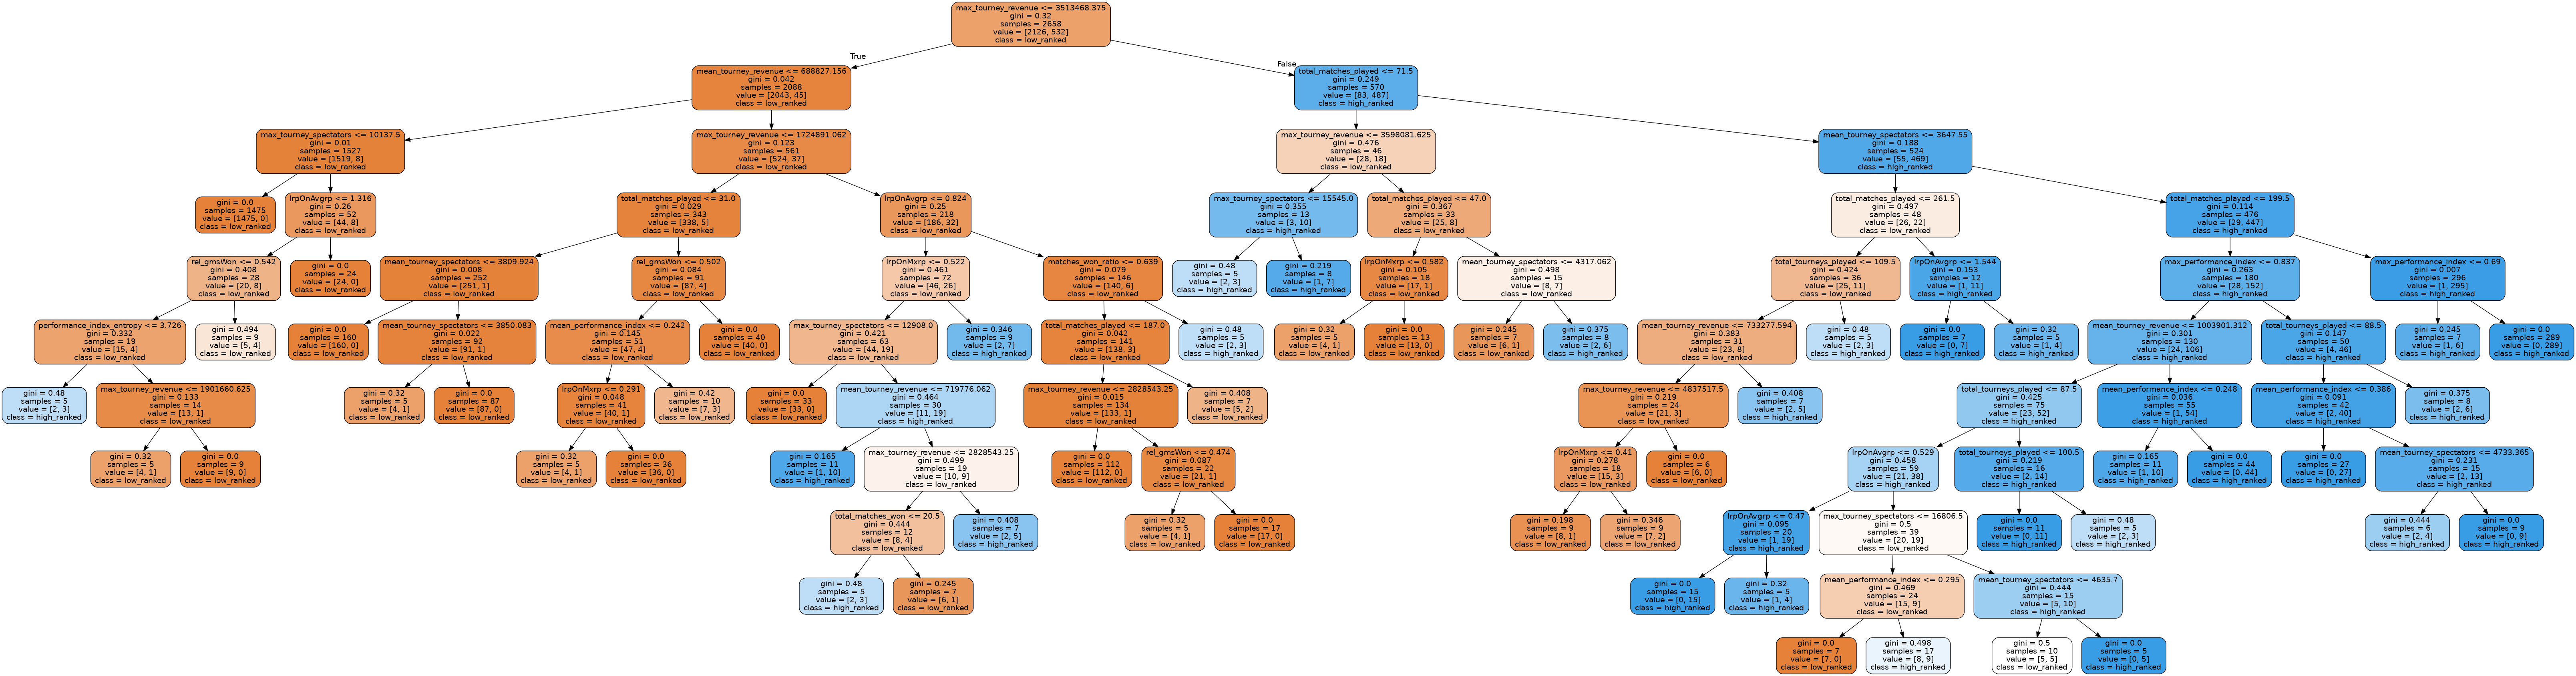

In [46]:
cdot_data = tree.export_graphviz(best_model["clf"], out_file=None,
                         feature_names=list(classification.x_train.columns),
                         class_names=classes,
                         filled=True, rounded=True)
graph = pydotplus.graph_from_dot_data(cdot_data)
Image(graph.create_png())

#### Feature importance

In [47]:
# get the names of the most important features according to the model
# map the feature importances to the feature names
feature_importances = pd.DataFrame({'feature': X.columns, 'importance': best_model["clf"].feature_importances_})
# sort according to the importance
feature_importances.sort_values('importance', ascending=False).reset_index(drop=True)

,feature,importance
0,max_tourney_revenue,0.824504
1,total_matches_played,0.048696
2,mean_tourney_spectators,0.033568
3,lrpOnAvgrp,0.023690
4,max_tourney_spectators,0.022174
5,mean_tourney_revenue,0.019167
6,mean_performance_index,0.005848
7,lrpOnMxrp,0.005632
8,total_tourneys_played,0.005211
9,matches_won_ratio,0.004214


### Rule based (RIPPER)

In [48]:
parameters = {"prune_size": [0.33, 0.5, 0.8], "k": [1, 2]}
best_model = classification.show_report("Ripper", lw.RIPPER(), parameters, validation_parameter='prune_size', normalization=False)

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

k,prune_size,mean_train_score,mean_test_score,rank_test_score
1,0.800000,0.954665,0.950716,1
2,0.800000,0.954665,0.950716,1
1,0.330000,0.958991,0.948836,3
2,0.330000,0.958991,0.948836,3
1,0.500000,0.961626,0.946200,5
2,0.500000,0.961626,0.946200,5


##### Validation metrics for the best model

Accuracy: 0.9507
F1: 0.8793
Precision: 0.8623
Recall: 0.8984


#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.97      0.97       912
 high_ranked       0.88      0.92      0.90       228

    accuracy                           0.96      1140
   macro avg       0.93      0.94      0.94      1140
weighted avg       0.96      0.96      0.96      1140



In [49]:
best_model["clf"].out_model()

[[max_tourney_revenue=>3724695.82 ^ total_tourneys_played=>112.0] V
[max_tourney_revenue=>3724695.82 ^ matches_won_ratio=>0.6] V
[max_tourney_revenue=>3724695.82 ^ total_tourneys_played=81.0-112.0 ^ mean_performance_index=0.33-0.38] V
[max_tourney_revenue=>3724695.82 ^ total_matches_played=170.6-239.0] V
[max_tourney_revenue=>3724695.82 ^ total_tourneys_played=40.0-56.0 ^ mean_tourney_spectators=>5224.1] V
[max_tourney_revenue=>3724695.82 ^ lrpOnAvgrp=<0.39] V
[max_tourney_revenue=>3724695.82 ^ max_performance_index=0.83-0.86 ^ matches_won_ratio=0.53-0.56] V
[max_tourney_spectators=>17634.0] V
[max_tourney_spectators=9485.0-15583.0 ^ max_performance_index=0.33-0.5 ^ max_tourney_revenue=1385835.6-1787950.47 ^ total_matches_played=37.0-54.0] V
[max_tourney_revenue=>3724695.82 ^ total_matches_played=114.0-170.6] V
[max_tourney_spectators=9485.0-15583.0 ^ total_matches_won=58.0-91.0 ^ lrpOnAvgrp=<0.39] V
[max_tourney_spectators=9485.0-15583.0 ^ max_tourney_revenue=1385835.6-1787950.47 ^ ma

### Random forest

In [50]:
parameters = {'max_depth': [2,3,4,5,6,7,8,9,10], 'n_estimators': [10, 20, 50, 100], 'max_features': range(1, len(classification.x_train.iloc[0]) + 1), 'bootstrap':[True, False], 'min_samples_leaf': [10, 20, 30, 40, 50], 'min_samples_split': [10, 20, 30, 40, 50]}
parameters = {'max_depth': [2,3,4,5,6,7,8,9,10], 'n_estimators': [10, 20, 50, 100], 'max_features': ['sqrt', 'log2', None], 'min_samples_leaf': [10, 20, 30, 40, 50], 'min_samples_split': [10, 20, 30, 40, 50]}
best_model = classification.show_report("Random Forest", RandomForestClassifier(), parameters, validation_parameter='max_depth', normalization=False)

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

max_depth,max_features,min_samples_leaf,min_samples_split,n_estimators,mean_train_score,mean_test_score,rank_test_score
5,None,10,20,50,0.972066,0.963884,1
5,None,10,10,50,0.972066,0.963884,1
10,None,10,20,100,0.973665,0.963883,3
7,None,10,10,100,0.973759,0.963883,3
8,None,10,10,100,0.973665,0.963883,3
9,None,10,10,100,0.973665,0.963883,3
7,None,10,10,50,0.973194,0.963883,3
10,None,10,10,100,0.973665,0.963883,3
8,None,10,20,100,0.973665,0.963883,3
9,None,10,20,100,0.973665,0.963883,3


##### Validation metrics for the best model

Accuracy: 0.9639
F1: 0.9101
Precision: 0.9051
Recall: 0.9154


#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.98      0.98       912
 high_ranked       0.91      0.92      0.91       228

    accuracy                           0.96      1140
   macro avg       0.94      0.95      0.95      1140
weighted avg       0.97      0.96      0.97      1140



### AdaBoost

In [51]:
parameters = {'n_estimators': [10, 20, 50, 100], 'algorithm': ['SAMME', 'SAMME.R'], 'learning_rate': [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]}
best_model = classification.show_report("AdaBoost", AdaBoostClassifier(), parameters, validation_parameter='n_estimators', normalization=False)

/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature nam

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

algorithm,learning_rate,n_estimators,mean_train_score,mean_test_score,rank_test_score
SAMME.R,0.500000,50,0.970655,0.962003,1
SAMME.R,0.300000,100,0.970937,0.961625,2
SAMME,1.000000,100,0.970185,0.961624,3
SAMME,0.700000,100,0.964824,0.960873,4
SAMME.R,0.200000,100,0.969338,0.960497,5
SAMME.R,0.700000,50,0.972536,0.960496,6
SAMME,0.500000,100,0.963318,0.960122,7
SAMME.R,1.000000,20,0.964823,0.959740,8
SAMME.R,1.000000,100,0.986550,0.958991,9
SAMME,1.000000,50,0.966328,0.958990,10


##### Validation metrics for the best model

Accuracy: 0.962
F1: 0.907
Precision: 0.8927
Recall: 0.923


/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature nam

/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature nam

#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.98      0.98       912
 high_ranked       0.91      0.93      0.92       228

    accuracy                           0.97      1140
   macro avg       0.95      0.95      0.95      1140
weighted avg       0.97      0.97      0.97      1140



### KNN

In [52]:
# Use SQRT heuristic on train set to find the optimal K
k_euristic = int(np.sqrt(len(classification.x_train))) + 1
# add 20% to k_euristic to get the upper bound
k_euristic = int(k_euristic * 1.2)
k_range = list(range(1, k_euristic, 2))

parameters = {'n_neighbors': k_range, 'weights':['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree', 'brute'], 'metric': ['euclidean', 'manhattan', 'minkowski', 'chebyshev']}
best_model = classification.show_report("KNN", KNeighborsClassifier(), parameters, validation_parameter='n_neighbors', normalization=True)

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

algorithm,metric,n_neighbors,weights,mean_train_score,mean_test_score,rank_test_score
kd_tree,manhattan,15,distance,1.000000,0.957861,1
ball_tree,manhattan,15,distance,1.000000,0.957861,1
brute,manhattan,15,distance,1.000000,0.957861,1
ball_tree,manhattan,13,distance,1.000000,0.957487,4
kd_tree,manhattan,13,distance,1.000000,0.957487,4
brute,manhattan,13,distance,1.000000,0.957487,4
ball_tree,manhattan,11,distance,1.000000,0.957110,7
kd_tree,manhattan,11,distance,1.000000,0.957110,7
brute,manhattan,11,distance,1.000000,0.957110,7
ball_tree,manhattan,25,distance,1.000000,0.956733,10


##### Validation metrics for the best model

Accuracy: 0.9579
F1: 0.8973
Precision: 0.8766
Recall: 0.9192


#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.97      0.98       912
 high_ranked       0.90      0.92      0.91       228

    accuracy                           0.96      1140
   macro avg       0.94      0.95      0.94      1140
weighted avg       0.96      0.96      0.96      1140



### Naive Bayes

In [53]:
parameters = {}
best_model = classification.show_report("Naive Bayes", GaussianNB(), parameters, validation_parameter='', normalization=False)

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

mean_train_score,mean_test_score,rank_test_score


##### Validation metrics for the best model

Accuracy: 0.9394
F1: 0.8602
Precision: 0.8003
Recall: 0.9304


#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.95      0.97       912
 high_ranked       0.83      0.93      0.88       228

    accuracy                           0.95      1140
   macro avg       0.91      0.94      0.92      1140
weighted avg       0.95      0.95      0.95      1140



### Support Vector Machine

In [54]:
parameters = {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
best_model = classification.show_report("SVM", SVC(probability=True), parameters, validation_parameter='C', normalization=True)

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

C,kernel,mean_train_score,mean_test_score,rank_test_score
10.000000,poly,0.975169,0.967266,1
100.000000,rbf,0.980530,0.966890,2
100.000000,poly,0.981847,0.966888,3
10.000000,rbf,0.972818,0.966514,4
1.000000,poly,0.969150,0.966141,5
1.000000,rbf,0.962001,0.960119,6
1000.000000,poly,0.989654,0.959743,7
1000.000000,rbf,0.992758,0.959742,8
0.100000,poly,0.962942,0.958991,9
1000.000000,linear,0.961155,0.957862,10


##### Validation metrics for the best model

Accuracy: 0.9673
F1: 0.9171
Precision: 0.9287
Recall: 0.906


#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.97      0.98      0.98       912
 high_ranked       0.92      0.90      0.91       228

    accuracy                           0.96      1140
   macro avg       0.95      0.94      0.94      1140
weighted avg       0.96      0.96      0.96      1140



### Neural Networks

In [55]:
parameters = {"solver": ['lbfgs', 'sgd', 'adam'], "alpha": [0.0001, 0.00001], "hidden_layer_sizes": [(10,), (20, )], "activation": ['tanh', 'relu'], "learning_rate": [ 'invscaling', 'adaptive'], "max_iter": [200, 400, 600, 800]}
best_model = classification.show_report("Neural Network", MLPClassifier(), parameters, validation_parameter='max_iter', normalization=True)

/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

#### VALIDATION Report

##### Top 10 results of the grid search with 5-fold cross validation

activation,alpha,hidden_layer_sizes,learning_rate,max_iter,solver,mean_train_score,mean_test_score,rank_test_score
relu,0.000010,"(20,)",adaptive,800,lbfgs,0.984199,0.962750,1
relu,0.000010,"(20,)",invscaling,800,lbfgs,0.984199,0.962750,1
relu,0.000010,"(20,)",adaptive,600,lbfgs,0.982224,0.962376,3
relu,0.000010,"(20,)",invscaling,600,lbfgs,0.982224,0.962376,3
relu,0.000010,"(20,)",invscaling,200,lbfgs,0.975169,0.962002,5
relu,0.000010,"(20,)",adaptive,200,lbfgs,0.975169,0.962002,5
tanh,0.000100,"(10,)",invscaling,200,lbfgs,0.979120,0.961248,7
tanh,0.000010,"(10,)",adaptive,200,lbfgs,0.979966,0.961248,7
tanh,0.000100,"(10,)",adaptive,200,lbfgs,0.979120,0.961248,7
tanh,0.000010,"(10,)",invscaling,200,lbfgs,0.979966,0.961248,7


##### Validation metrics for the best model

Accuracy: 0.9639
F1: 0.909
Precision: 0.9164
Recall: 0.9022


/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/reuseman/.miniconda3/envs/dm/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning:

#### TEST Report

##### Confusion matrix for the best classifier obtained by the Grid Search on the TEST set

##### Metrics for the best classifier on the TEST set

              precision    recall  f1-score   support

  low_ranked       0.98      0.97      0.98       912
 high_ranked       0.89      0.93      0.91       228

    accuracy                           0.96      1140
   macro avg       0.94      0.95      0.94      1140
weighted avg       0.96      0.96      0.96      1140



## Result analysis

### Comparison (ROC)

In [56]:
fig = go.Figure()
fig.add_shape(type="line", x0=0, y0=0, x1=1, y1=1, line=dict(color="RoyalBlue",width=3, dash="dash"))

models = classification.get_best_models()

for i in range(len(models)):
    y_score = models[i][1].predict_proba(classification.x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(classification.y_test, y_score)
    auc_score = roc_auc_score(classification.y_test, y_score)
    models[i] += (auc_score,)
    
# Sort according to AUC score
models.sort(key=lambda x: x[2], reverse=True)  
for model in models:
    y_score = model[1].predict_proba(classification.x_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(classification.y_test, y_score)
    name = f"{model[0]} - AUC={model[2]:.3f}"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'),
    width=700, height=500)
fig.show()

### Accuracy of all models on train and test set

In [57]:
df_accuracy_train = pd.DataFrame()
df_accuracy_train['Model'] = [model[0] for model in models]
df_accuracy_train['Accuracy'] = [model[1].score(classification.x_train, classification.y_train) for model in models]
df_accuracy_train['Set'] = ['Train' for model in models]

df_accuracy_test = pd.DataFrame()
df_accuracy_test['Model'] = [model[0] for model in models]
df_accuracy_test['Accuracy'] = [model[1].score(classification.x_test, classification.y_test) for model in models]
df_accuracy_test['Set'] = ['Test' for model in models]

# merge the dataframes
df_accuracy = pd.concat([df_accuracy_train, df_accuracy_test]).reset_index(drop=True)
df_accuracy = df_accuracy.sort_values(by=['Set', 'Accuracy', 'Model'], ascending=[1, 0, 1]).reset_index(drop=True)
df_accuracy['Accuracy'] = df_accuracy['Accuracy'].round(4)

# plotly express barcharth for each model with the train and test accuracy
px.bar(df_accuracy, x="Model", y="Accuracy", color="Set", barmode="group", text_auto=True, color_discrete_sequence=["firebrick", "royalblue"]).show()

### F1, Accuracy, Precision, Recall on test set

In [58]:
df_metrics = pd.DataFrame()
df_metrics['Model'] = [model[0] for model in models]

df_f1 = pd.DataFrame()
df_f1['Model'] = [model[0] for model in models]
df_f1['Score'] = [f1_score(classification.y_test, model[1].predict(classification.x_test)) for model in models]
df_f1['Metric'] = ['F1' for model in models]
df_f1['Score'] = df_f1['Score'].round(4)
df_f1 = df_f1.sort_values(by="Score", ascending=False)

df_accuracy_test = pd.DataFrame()
df_accuracy_test['Model'] = [model[0] for model in models]
df_accuracy_test['Score'] = [model[1].score(classification.x_test, classification.y_test) for model in models]
df_accuracy_test['Metric'] = ['Accuracy' for model in models]

# precision
df_precision = pd.DataFrame()
df_precision['Model'] = [model[0] for model in models]
df_precision['Score'] = [precision_score(classification.y_test, model[1].predict(classification.x_test)) for model in models]
df_precision['Metric'] = ['Precision' for model in models]

#recall
df_recall = pd.DataFrame()
df_recall['Model'] = [model[0] for model in models]
df_recall['Score'] = [recall_score(classification.y_test, model[1].predict(classification.x_test)) for model in models]
df_recall['Metric'] = ['Recall' for model in models]

df_metrics = pd.concat([df_f1, df_accuracy_test, df_precision, df_recall]).reset_index(drop=True)
df_metrics["Score"] = df_metrics["Score"].round(4)

px.bar(df_metrics, x="Model", y="Score", color="Metric", barmode="group", text_auto=True, color_discrete_sequence=["firebrick", "royalblue", "#FFBF00", "#32936F"]).show()

### PCA Visualization of the best model

In [59]:
# Search for the model with the best AUC score
best_model = max(models, key=lambda x: x[2])

PCAdata = MinMaxScaler().fit_transform(classification.x_train)
X_r = pd.DataFrame(PCA(n_components=2).fit_transform(PCAdata))
prediction = best_model[1].predict_proba(classification.x_train)

fig = px.scatter(x=X_r[0], y=X_r[1], color=prediction[:, 1], color_continuous_scale='RdBu', symbol=classification.y_train, symbol_map={'0': 'square-dot', '1': 'circle-dot'},  labels={'symbol': 'label', 'color': 'score of <br>first class'})
fig.update_traces(marker_size=12, marker_line_width=1.5)
fig.update_layout(title=f"PCA visualization for {best_model[0]}", legend_orientation='h')
fig.show()

### Comparison with K-means

In [60]:
# Apply k-means to identify cluster of good and bad players
from sklearn.cluster import KMeans

feautures = ['max_tourney_revenue', 'mean_rank_points', 'lrpOnMxrp', 'matches_won_ratio']
df_data = df_players_complete[feautures].reset_index(drop=True)
df_data = pd.DataFrame(MinMaxScaler().fit_transform(df_data), columns=df_data.columns)
df_data = df_data.round(3)
kmeans = KMeans(n_clusters=2, n_init=10, max_iter=100, init="k-means++", random_state=42).fit(df_data)
df_players_complete['cluster'] = kmeans.labels_

df_players_complete["classification"] = best_model[1].predict(df_players.drop(columns="is_high_ranked"))

# Show confusion matrix to see the intersection between classification and cluster
cm = confusion_matrix(df_players_complete["cluster"], df_players_complete["classification"])
fig = ff.create_annotated_heatmap(cm[[1, 0]], x=["Low ranked","High ranked"], y=["Low ranked", "High ranked"], colorscale='Blues', showscale=True)
fig.update_layout(xaxis = dict(title='Predicted value'), yaxis = dict(title='K-means'))
fig.show()